# Ковидын эерэг болон сөрөг 2 ангилалын загвар

## Сангуудаа импортлох

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D, Dropout

## Өгөгдлөө унших

In [3]:
dataset = pd.read_csv('../../input/augmented_data/spectrum.csv', low_memory=False)

In [4]:
display(dataset.head().T, dataset.shape)

,0,1,2,3,4
320,23.767617,6.554332,-65.876227,-3.539452,-32.211329
321,8.541673,-3.982771,-52.107447,-25.36141,3.569451
322,-6.737708,-12.508809,-43.797257,-22.890028,-25.360113
323,-13.844851,-14.161707,-34.973131,-15.633461,-24.382165
324,-15.338898,-11.528857,-24.758405,-24.196508,-13.837212
...,...,...,...,...,...
classfication,0,0,0,0,0
negpos,0,0,0,0,0
medium,NaN,NaN,NaN,NaN,NaN
mediumclassification,NaN,NaN,NaN,NaN,NaN


(6400, 1338)

## Өгөгдлөө бэлдэх

In [19]:
def preprocess_data(dataset):
    labels = dataset.columns[-7:]
    dataset = dataset[dataset['covid_status'] == 'negative']
    X = dataset.drop(labels, axis=1)
    X.columns = X.columns.astype(int)
    y = dataset['classfication']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train, X_test, y_train_encoded, y_test_encoded

In [20]:
X_train, X_test, y_train, y_test = preprocess_data(dataset)

In [21]:
_ , counts = np.unique(y_train, return_counts=True)
print('Train set: ', counts)
_ , counts = np.unique(y_test, return_counts=True)
print('Test set: ', counts)

Train set:  [750 225]
Test set:  [250  75]


In [23]:
NUM_EPOCHS = 50

In [38]:
def simple_cnn(X_train, X_test, y_train, y_test, num_epochs=NUM_EPOCHS):

    model = Sequential([
        Conv1D(16, 21, input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(16),

        Conv1D(32, 11),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(8),

        Conv1D(64, 5),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(4),
        
        Flatten(),
        BatchNormalization(),

        Dense(2048, activation='tanh'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    for i in range(num_epochs):
        history = model.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

        test_loss.append(loss)
        test_accuracy.append(accuracy)
        if (i + 1) % 5 == 0:
            print(f'Epoch {i+1} => Test Loss: {loss:.2f} - Test Accuracy: {accuracy*100:.2f}%')

    # fig, axs = plt.subplots(ncols=2)
    # axs[0].plot(train_accuracy, label='train_accuracy')
    # axs[0].plot(test_accuracy, label='test_accuracy')
    # axs[0].title('Model accuracy')
    # axs[0].xlabel('Epoch')
    # axs[0].ylabel('Accuracy')

    # axs[1].plot(train_loss, label='train_loss')
    # axs[1].plot(test_loss, label='test_loss')
    # axs[1].title('Model loss')
    # axs[1].xlabel('Epoch')
    # axs[1].ylabel('Loss')

    # plt.tight_layout()
    # plt.show()

    return model

In [39]:
lenet_model = simple_cnn(X_train, X_test, y_train, y_test)

Epoch 5 => Test Loss: 0.02 - Test Accuracy: 99.69%
Epoch 10 => Test Loss: 0.01 - Test Accuracy: 100.00%
Epoch 15 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 20 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 25 => Test Loss: 0.00 - Test Accuracy: 99.69%
Epoch 30 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 35 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 40 => Test Loss: 0.01 - Test Accuracy: 99.38%
Epoch 45 => Test Loss: 0.06 - Test Accuracy: 99.69%
Epoch 50 => Test Loss: 0.00 - Test Accuracy: 100.00%


11/11 [==============================] - 0s 2ms/step


,0,1,2,3,4,5,6,7,8,9,...,315,316,317,318,319,320,321,322,323,324
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


,0,1,2,3,4,5,6,7,8,9,...,315,316,317,318,319,320,321,322,323,324
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


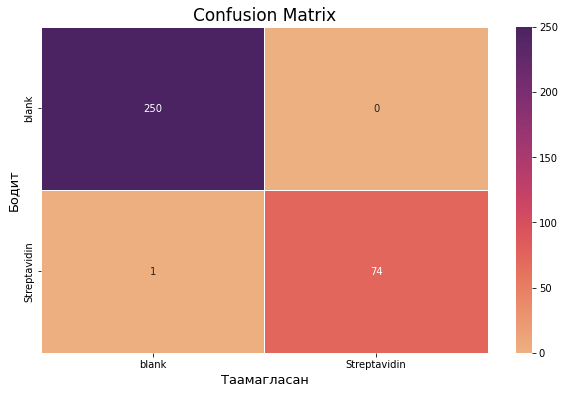

In [40]:
y_pred = lenet_model.predict(X_test)
y_pred = y_pred.astype(int).reshape(-1)
display(pd.DataFrame(y_test).T, pd.DataFrame(y_pred).T)

cm = confusion_matrix(y_test, y_pred)

category_labels = ['blank', 'Streptavidin']
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.heatmap(cm, 
            ax=ax,
            annot=True,
            cmap="flare",
            linewidth=.5,
            fmt='g', 
            xticklabels=category_labels,
            yticklabels=category_labels)
plt.xlabel('Таамагласан',fontsize=13)
plt.ylabel('Бодит',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [41]:
tp, fn, fp, tn = cm.ravel()
print(f"TP: {tp} FN: {fn} \nFP: {fp} TN: {tn}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score (Sensitivity): {recall:.4f}")

sensitivity_ = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print(f"Sensitivity: {100 * sensitivity_:.2f}%")
print(f"Specificity: {100 * specificity:.2f}%")
print(f"Accuracy: {100 * accuracy:.2f}%")

TP: 250 FN: 0 
FP: 1 TN: 74
Recall Score (Sensitivity): 0.9867
Sensitivity: 100.00%
Specificity: 98.67%
Accuracy: 99.69%
